In [ ]:
# Install required packages in a virtual environment (This code is currently only tested with Python 3.13.3)
%pip install pandas==2.2.3
%pip install matplotlib==3.10.1

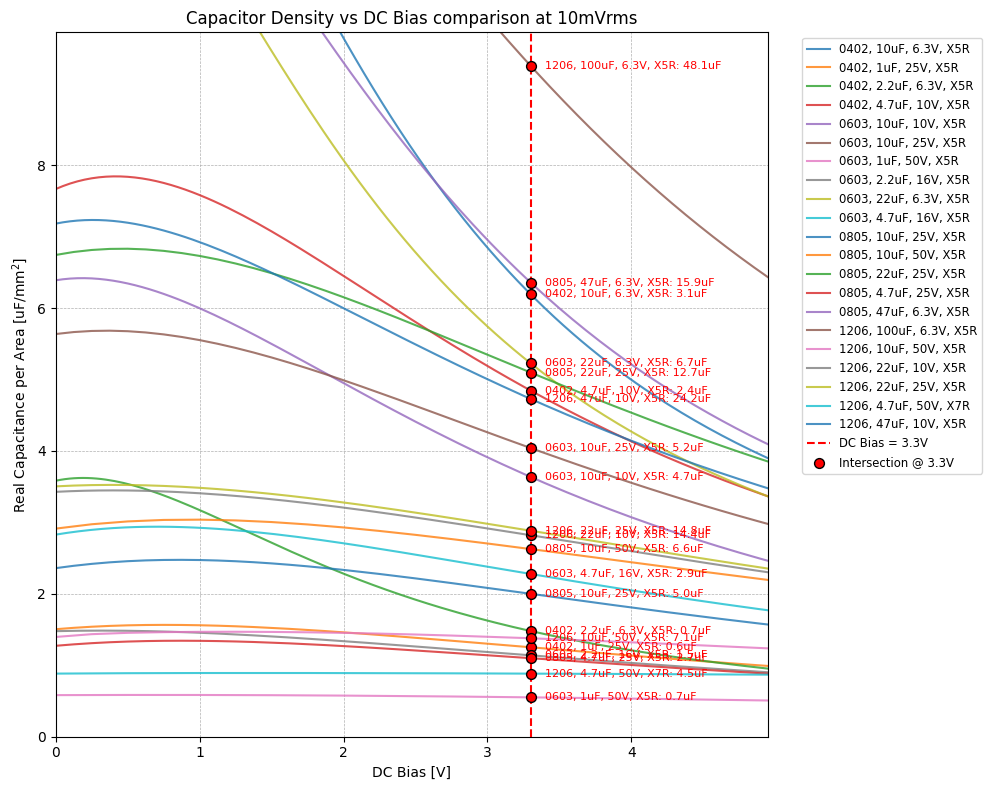


Processed 21 relevant capacitor files.
Found 21 intersection points at 3.3V.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np

# --- Configuration ---
csv_folder_path = 'SimSurfing Bias Derating CSVs'
target_voltage = 3.3 # Define the DC Bias voltage for the vertical line
voltage_cutoff = target_voltage*1.5 # Define the max DC Bias voltage shown on the graph
# -------------------

# Define standard dimensions (Length x Width) in mm for area calculation
package_dimensions_mm = {
    '0402': {'L': 1.0, 'W': 0.5},
    '0603': {'L': 1.6, 'W': 0.8},
    '0805': {'L': 2.0, 'W': 1.25},
    '1206': {'L': 3.2, 'W': 1.6}
}

# Calculate area in mm^2
package_areas_mm2 = {
    pkg: dims['L'] * dims['W']
    for pkg, dims in package_dimensions_mm.items()
}

# Find all CSV files in the specified folder
try:
    all_csv_files = glob.glob(os.path.join(csv_folder_path, '*.csv'))
    if not all_csv_files:
        print(f"Error: No CSV files found in the directory: '{csv_folder_path}'")
        print("Please ensure the 'csv_folder_path' variable is set correctly.")
        exit()
except Exception as e:
    print(f"Error accessing directory '{csv_folder_path}': {e}")
    exit()


# --- Data Processing and Plotting ---
plt.figure(figsize=(12, 8))

processed_files = 0
intersection_points_x = [] # List to store x-coords of intersections
intersection_points_y = [] # List to store y-coords of intersections
intersection_labels = []   # Store labels for hover/annotation later

for file_path in all_csv_files:
    file_name = os.path.basename(file_path)
    parts = [p.strip() for p in file_name.replace('.csv', '').split(',')]

    if len(parts) < 4:
        # print(f"Skipping file (unexpected format): {file_name}") # Keep this commented unless debugging format issues
        continue

    package = parts[0]

    if package not in package_areas_mm2:
        continue

    try:
        rated_capacitance_str = parts[1]
        voltage_str = parts[2]
        dielectric = parts[3]
        label = f"{package}, {rated_capacitance_str}, {voltage_str}, {dielectric}"

        df = pd.read_csv(file_path, comment='#')

        if 'DC Bias[V]' not in df.columns or 'Capacitance[F]' not in df.columns:
             print(f"Skipping file (missing required columns): {file_name}")
             continue

        df['DC Bias[V]'] = pd.to_numeric(df['DC Bias[V]'], errors='coerce')
        df['Capacitance[F]'] = pd.to_numeric(df['Capacitance[F]'], errors='coerce')
        df.dropna(subset=['DC Bias[V]', 'Capacitance[F]'], inplace=True)
        df.sort_values('DC Bias[V]', inplace=True)


        if df.empty:
            print(f"Skipping file (no valid numeric data): {file_name}")
            continue

        area_mm2 = package_areas_mm2[package]
        df['Capacitance_uF_per_mm2'] = (df['Capacitance[F]'] * 1e6) / area_mm2

        # Plot the main curve
        plt.plot(df['DC Bias[V]'], df['Capacitance_uF_per_mm2'], label=label, alpha=0.8)

        # --- Find and store intersection point ---
        # Check if target voltage is within the range of the data for this cap
        min_v = df['DC Bias[V]'].min()
        max_v = df['DC Bias[V]'].max()

        if min_v <= target_voltage <= max_v:
            # Interpolate capacitance density at the target voltage
            # np.interp(x_to_interp, x_values, y_values)
            interpolated_cap_density = np.interp(
                target_voltage,
                df['DC Bias[V]'], # x-values (must be increasing)
                df['Capacitance_uF_per_mm2'] # y-values
            )
            
            interpolated_capacitance = np.interp(
                target_voltage,
                df['DC Bias[V]'],
                df['Capacitance[F]'] * 1e6
            )
            
            
            intersection_points_x.append(target_voltage)
            intersection_points_y.append(interpolated_cap_density)
            intersection_labels.append(f"{label}: {interpolated_capacitance:.1f}uF")

        processed_files += 1

    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except pd.errors.EmptyDataError:
        print(f"Skipping empty or improperly formatted file: {file_name}")
    except KeyError as e:
        print(f"Skipping file {file_name} due to missing key: {e}")
    except Exception as e:
        print(f"An unexpected error occurred processing {file_name}: {e}")


# --- Final Plot Configuration ---
if processed_files > 0:
    # --- Plot Vertical Line and Intersection Points ---
    # Draw the vertical line at the target voltage
    plt.axvline(x=target_voltage, color='red', linestyle='--', linewidth=1.5, label=f'DC Bias = {target_voltage}V', zorder=3)

    # Plot the collected intersection points as markers
if intersection_points_x: # Only plot if intersections were found
    plt.scatter(intersection_points_x, intersection_points_y,
                color='red',        # Color of the marker
                marker='o',         # Shape of the marker
                s=50,               # Size of the marker
                edgecolor='black',  # Optional: edge color for visibility
                zorder=5,           # Draw points on top of lines
                label=f'Intersection @ {target_voltage}V')
    
    # Add annotations for each intersection point
    for x, y, lbl in zip(intersection_points_x, intersection_points_y, intersection_labels):
        plt.annotate(
            lbl, 
            (x, y),                   # Point to annotate
            xytext=(10, 0),           # Offset from point (10 points right, 0 up)
            textcoords='offset points',  # Coordinate system for offset
            ha='left',                # Horizontal alignment
            va='center',              # Vertical alignment
            fontsize=8,               # Smaller font size for compact labels
            color='red',              # Match point color
            zorder=6                  # Draw above scatter points
        )


    plt.title('Capacitor Density vs DC Bias comparison at 10mVrms')
    plt.xlabel('DC Bias [V]')
    plt.ylabel('Real Capacitance per Area [uF/mm$^2$]')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)


    # Place legend outside the plot
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize='small')
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout if legend is outside

    plt.xlim(0, voltage_cutoff)
    plt.ylim(0, max(intersection_points_y)*1.05)

    plt.show()
else:
    print("\nNo valid data processed or plotted. Check file paths, formats, and package names.")

print(f"\nProcessed {processed_files} relevant capacitor files.")
if intersection_points_x:
    print(f"Found {len(intersection_points_x)} intersection points at {target_voltage}V.")